# LightGBM Model Experiment for Walmart Sales Forecasting

This notebook implements and experiments with LightGBM for time series forecasting

## Setup and Installations

In [3]:
# Install required packages
!pip install lightgbm
!pip install mlflow
!pip install dagshub
!pip install joblib
!pip install optuna
!pip install scikit-learn
!pip install optuna-integration[lightgbm]


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import joblib
import pickle

# MLflow and experiment tracking
import mlflow
import mlflow.lightgbm
import dagshub

# Hyperparameter optimization
import optuna
from optuna.integration import LightGBMPruningCallback

# Set working directory
os.chdir('/content/drive/MyDrive/ML-Final')

## MLflow Setup and Data Loading

In [5]:
# Initialize MLflow
dagshub.init(repo_owner='egval20', repo_name='ML-Final', mlflow=True)
mlflow.set_experiment("LightGBM_Walmart_Sales")

# Load preprocessing pipeline
def get_model_ready_data(pipeline_path='preprocessing_pipeline.pkl'):
    """Load the preprocessing pipeline and return data preparation function"""
    pipeline = joblib.load(pipeline_path)

    def preprocess_for_model(raw_data):
        return pipeline.transform(raw_data)

    return preprocess_for_model, pipeline

# Load raw data
print("Loading raw data...")
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

print(f"Train shape: {train_raw.shape}")
print(f"Test shape: {test_raw.shape}")
print(f"Date range - Train: {train_raw['Date'].min()} to {train_raw['Date'].max()}")
print(f"Date range - Test: {test_raw['Date'].min()} to {test_raw['Date'].max()}")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=58d32cff-7f40-4867-89ab-c997fdfad4bc&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=4b8776b1a0e43c355769b8dc63b34a54fb232852938063338bc0816e2c592c55




Accessing as lagorg22

Initialized MLflow to track repo "egval20/ML-Final"

Repository egval20/ML-Final initialized!

Loading raw data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Date range - Train: 2010-02-05 to 2012-10-26
Date range - Test: 2012-11-02 to 2013-07-26


## Data Preprocessing

In [6]:
# Load and apply preprocessing pipeline
print("Loading preprocessing pipeline...")
preprocess_fn, loaded_pipeline = get_model_ready_data()

# Apply preprocessing
print("Applying preprocessing...")
train_processed = preprocess_fn(train_raw)
test_processed = preprocess_fn(test_raw)

# Prepare features and target
X_train = train_processed[loaded_pipeline.feature_names_]
y_train = train_processed['Weekly_Sales']
X_test = test_processed[loaded_pipeline.feature_names_]

print(f"Preprocessed train shape: {X_train.shape}")
print(f"Preprocessed test shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")

Loading preprocessing pipeline...
Applying preprocessing...
Preprocessed train shape: (421570, 62)
Preprocessed test shape: (115064, 62)
Target shape: (421570,)


## Data Analysis and Visualization


=== DATA ANALYSIS ===
Target variable (Weekly_Sales) statistics:
count    421570.000000
mean      15981.676377
std       22710.889199
min           0.000000
25%        2079.757500
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

Missing values in features:
Sales_Lag_1       3331
Sales_Lag_2       6625
Sales_Lag_3       9889
Sales_Lag_4      13134
Sales_Lag_8      25966
Sales_Lag_52    160487
Sales_MA_4        3331
Sales_STD_4       6625
Sales_MA_8        3331
Sales_STD_8       6625
Sales_MA_12       3331
Sales_STD_12      6625
dtype: int64


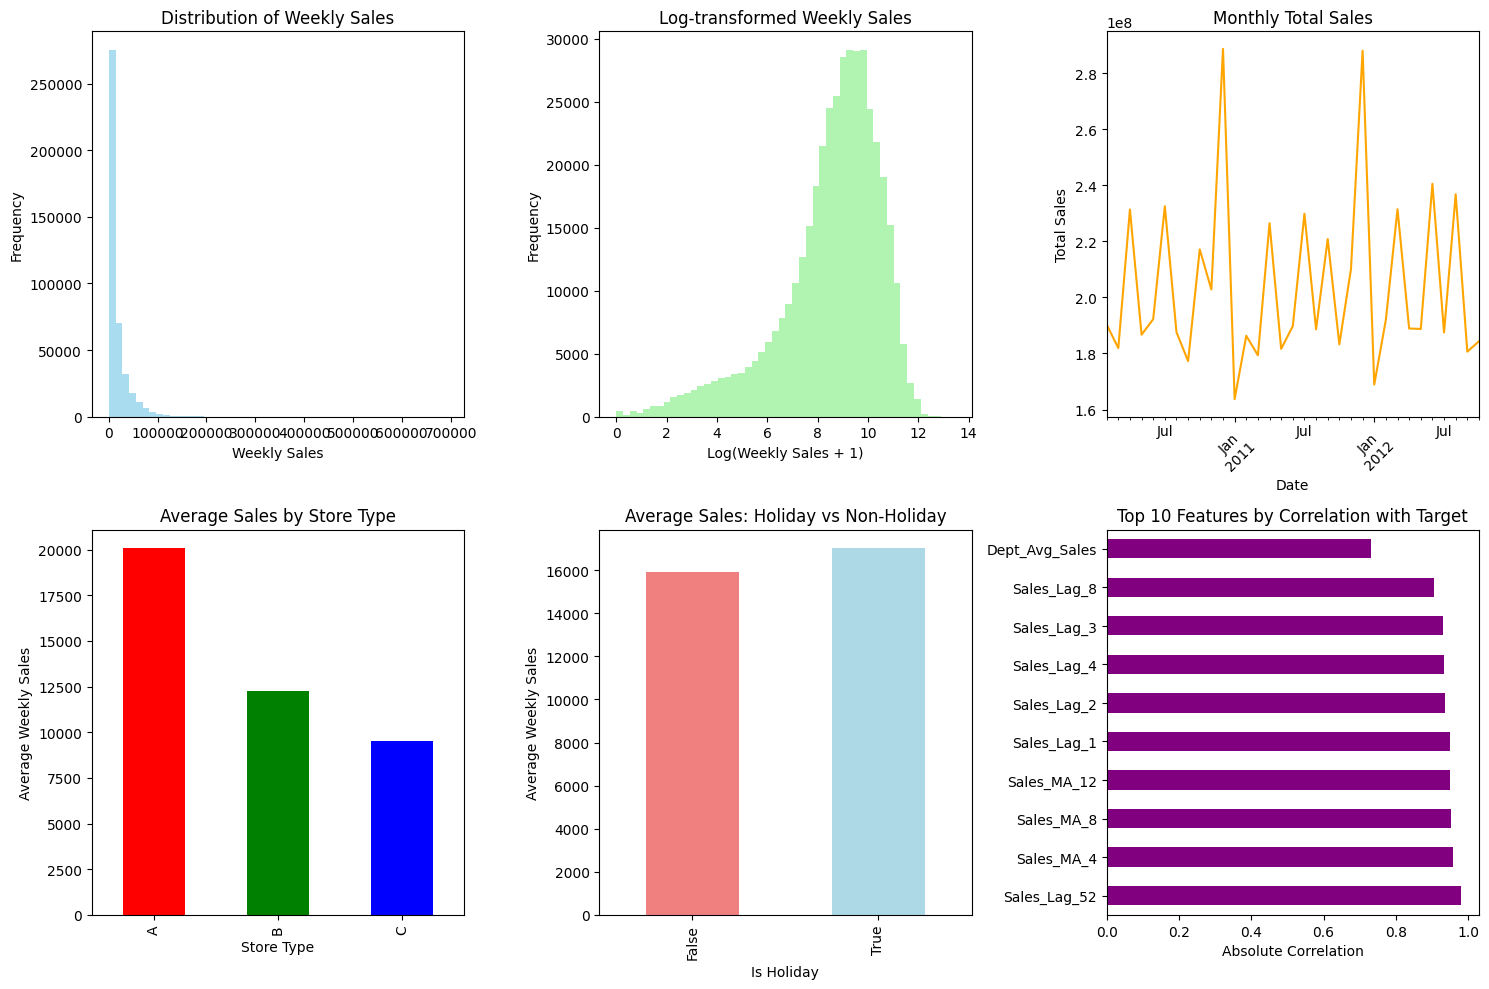

In [7]:
# Basic statistics
print("\n=== DATA ANALYSIS ===")
print(f"Target variable (Weekly_Sales) statistics:")
print(y_train.describe())

print(f"\nMissing values in features:")
missing_values = X_train.isnull().sum()
print(missing_values[missing_values > 0])

# Visualizations
plt.figure(figsize=(15, 10))

# Target distribution
plt.subplot(2, 3, 1)
plt.hist(y_train, bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

# Log-transformed target distribution
plt.subplot(2, 3, 2)
plt.hist(np.log1p(y_train), bins=50, alpha=0.7, color='lightgreen')
plt.title('Log-transformed Weekly Sales')
plt.xlabel('Log(Weekly Sales + 1)')
plt.ylabel('Frequency')

# Sales over time
plt.subplot(2, 3, 3)
# Ensure 'Date' column is in train_processed and is datetime type
if 'Date' in train_processed.columns:
    train_processed['Date'] = pd.to_datetime(train_processed['Date'])
    monthly_sales = train_processed.groupby(train_processed['Date'].dt.to_period('M'))['Weekly_Sales'].sum()
    monthly_sales.plot(kind='line', color='orange')
    plt.title('Monthly Total Sales')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
else:
    print("'Date' column not found in train_processed. Skipping Sales over time plot.")


# Sales by store type
plt.subplot(2, 3, 4)
# Ensure 'Type' column is in train_processed
if 'Type' in train_processed.columns:
    store_type_sales = train_processed.groupby('Type')['Weekly_Sales'].mean()
    store_type_sales.plot(kind='bar', color=['red', 'green', 'blue'])
    plt.title('Average Sales by Store Type')
    plt.xlabel('Store Type')
    plt.ylabel('Average Weekly Sales')
else:
    print("'Type' column not found in train_processed. Skipping Sales by store type plot.")

# Holiday effect
plt.subplot(2, 3, 5)
# Ensure 'IsHoliday' column is in train_processed
if 'IsHoliday' in train_processed.columns:
    holiday_sales = train_processed.groupby('IsHoliday')['Weekly_Sales'].mean()
    holiday_sales.plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Average Sales: Holiday vs Non-Holiday')
    plt.xlabel('Is Holiday')
    plt.ylabel('Average Weekly Sales')
else:
     print("'IsHoliday' column not found in train_processed. Skipping Holiday effect plot.")


# Feature importance preview (top 10 features by correlation)
plt.subplot(2, 3, 6)
# Select only numeric columns for correlation calculation
numeric_cols = X_train.select_dtypes(include=np.number).columns
correlations = X_train[numeric_cols].corrwith(y_train).abs().sort_values(ascending=False)
top_10_corr = correlations.head(10)
top_10_corr.plot(kind='barh', color='purple')
plt.title('Top 10 Features by Correlation with Target')
plt.xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()

## Custom Evaluation Metrics

In [8]:
def weighted_mae(y_true, y_pred, is_holiday):
    """
    Calculate Weighted Mean Absolute Error (WMAE) as used in Kaggle competition
    Holiday weeks have weight 5, non-holiday weeks have weight 1
    """
    weights = np.where(is_holiday, 5, 1)
    mae = np.abs(y_true - y_pred)
    wmae = np.sum(weights * mae) / np.sum(weights)
    return wmae

def lgb_wmae(y_pred, y_true):
    """
    LightGBM compatible WMAE metric
    Note: This is a simplified version as we don't have holiday info in validation
    LightGBM reports MAE as 'l1'
    """
    mae = np.mean(np.abs(y_true.get_label() - y_pred))
    return 'wmae', mae, False

## Time Series Cross-Validation Setup

In [9]:
class TimeSeriesValidator:
    """Custom time series validation for Walmart data"""

    def __init__(self, n_splits=5, test_size_weeks=8):
        self.n_splits = n_splits
        self.test_size_weeks = test_size_weeks

    def split(self, X, y, groups=None):
        """Generate time series splits"""
        # Convert to datetime if needed
        if 'Date' in X.columns:
            dates = pd.to_datetime(X['Date'])
        else:
            # Reconstruct dates from train_processed
            dates = pd.to_datetime(train_processed['Date'])

        # Sort by date
        sorted_indices = dates.argsort()
        sorted_dates = dates.iloc[sorted_indices]

        # Calculate split points
        unique_dates = sorted_dates.unique()
        total_weeks = len(unique_dates)

        for i in range(self.n_splits):
            # Calculate train/test split point
            test_start_idx = total_weeks - self.test_size_weeks * (self.n_splits - i)
            test_end_idx = total_weeks - self.test_size_weeks * (self.n_splits - i - 1)

            if test_start_idx <= 0:
                continue

            train_end_date = unique_dates[test_start_idx - 1]
            test_start_date = unique_dates[test_start_idx]
            test_end_date = unique_dates[min(test_end_idx - 1, total_weeks - 1)]

            # Get indices
            train_mask = dates <= train_end_date
            test_mask = (dates >= test_start_date) & (dates <= test_end_date)

            train_indices = np.where(train_mask)[0]
            test_indices = np.where(test_mask)[0]

            yield train_indices, test_indices

## LightGBM Model Training Functions

In [10]:
def train_lightgbm_baseline(X_train, y_train, X_val=None, y_val=None):
    """Train baseline LightGBM model with default parameters"""

    # Basic parameters
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }

    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)

    if X_val is not None and y_val is not None:
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        valid_sets = [train_data, val_data]
        valid_names = ['train', 'val']
    else:
        valid_sets = [train_data]
        valid_names = ['train']

    # Train model
    model = lgb.train(
        params,
        train_data,
        valid_sets=valid_sets,
        valid_names=valid_names,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        # verbose_eval=100 # verbose_eval should be outside callbacks list. It is already outside and set to 100 in the original code.
    )

    return model

def train_lightgbm_optimized(X_train, y_train, X_val=None, y_val=None, n_trials=100):
    """Train LightGBM with Optuna hyperparameter optimization"""

    def objective(trial):
        # Hyperparameters to optimize
        params = {
            'objective': 'regression',
            'metric': 'l1',  # make sure to match with LightGBMPruningCallback
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 10, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'verbose': -1,
            'random_state': 42
        }

        # Create datasets
        train_data = lgb.Dataset(X_train, label=y_train)

        valid_sets = [train_data]
        valid_names = ['train']
        callbacks = [lgb.early_stopping(stopping_rounds=50)]

        if X_val is not None and y_val is not None:
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            valid_sets.append(val_data)
            valid_names.append('valid_0')  # Must match what Optuna expects
            callbacks.append(LightGBMPruningCallback(trial, 'l1'))

        # Train model
        model = lgb.train(
            params,
            train_data,
            valid_sets=valid_sets,
            valid_names=valid_names,
            num_boost_round=1000,
            callbacks=callbacks
        )
        print("lgb.train completed in objective function.")  # Debugging

        # Return validation score
        if X_val is not None:
            preds = model.predict(X_val, num_iteration=model.best_iteration)
            return mean_absolute_error(y_val, preds)
        else:
            return model.best_score['train']['l1']

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Best parameters: {study.best_params}")
    print(f"Best score: {study.best_value}")

    return study.best_params


## Model Training and Evaluation

=== TRAINING BASELINE LIGHTGBM MODEL ===
Performing time series cross-validation...

Fold 1
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 1230.02	val's l1: 1272.14
Fold 1 MAE: 1272.1439

Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[898]	train's l1: 1250.48	val's l1: 1198.03
Fold 2 MAE: 1198.0341

Fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[908]	train's l1: 1235.77	val's l1: 1169.48
Fold 3 MAE: 1169.4776

Cross-validation results:
Average MAE: 1213.2185 (+/- 43.2667)

Training final model on all training data...

Top 20 Most Important Features:
                feature    importance
27          Sales_Lag_1  1.047752e+15
33           Sales_MA_4  5.496695e+14
32         Sales_Lag_52  2.725616e+13
35           Sales_MA_8  2.533613e+13
30          Sales_Lag_4  1.226214e+13
46       Dept_Std_Sal

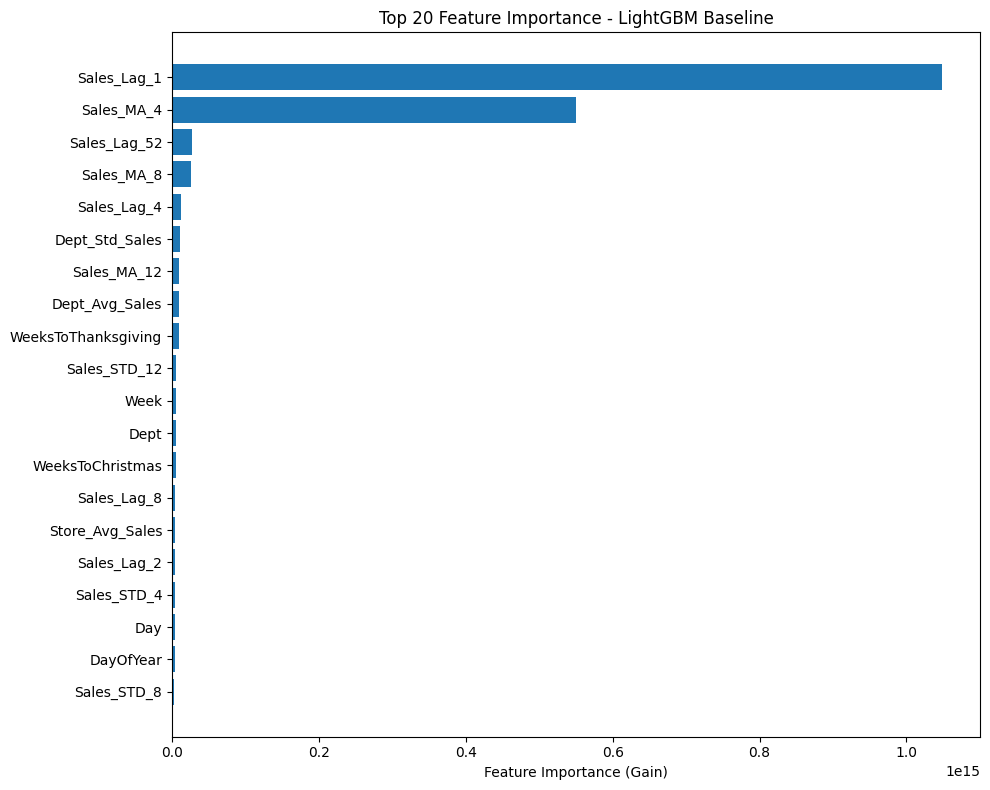

🏃 View run LightGBM_Baseline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/2/runs/85c7e9b6f6b144caa78a33fe2e7d970e
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/2


In [11]:
# Start MLflow run for baseline model
with mlflow.start_run(run_name="LightGBM_Baseline"):

    print("=== TRAINING BASELINE LIGHTGBM MODEL ===")

    # Temporarily drop non-numeric columns for LightGBM compatibility
    # NOTE: This is a temporary fix. The preprocessing pipeline should handle this.
    X_train_numeric = X_train.select_dtypes(include=np.number)
    y_train_numeric = y_train # y_train is already numeric

    # Log parameters
    mlflow.log_param("model_type", "LightGBM_Baseline")
    mlflow.log_param("n_features", X_train_numeric.shape[1])
    mlflow.log_param("n_samples", X_train_numeric.shape[0])

    # Time series cross-validation
    validator = TimeSeriesValidator(n_splits=3, test_size_weeks=8)
    cv_scores = []
    feature_importance_sum = np.zeros(X_train_numeric.shape[1]) # Use numeric features for importance

    print("Performing time series cross-validation...")
    for fold, (train_idx, val_idx) in enumerate(validator.split(X_train_numeric, y_train_numeric)): # Use numeric data
        print(f"\nFold {fold + 1}")

        X_fold_train = X_train_numeric.iloc[train_idx]
        y_fold_train = y_train_numeric.iloc[train_idx]
        X_fold_val = X_train_numeric.iloc[val_idx]
        y_fold_val = y_train_numeric.iloc[val_idx]

        # Train model
        model = train_lightgbm_baseline(X_fold_train, y_fold_train, X_fold_val, y_fold_val)

        # Evaluate
        val_preds = model.predict(X_fold_val, num_iteration=model.best_iteration)
        val_mae = mean_absolute_error(y_fold_val, val_preds)
        cv_scores.append(val_mae)

        # Accumulate feature importance
        feature_importance_sum += model.feature_importance(importance_type='gain')

        print(f"Fold {fold + 1} MAE: {val_mae:.4f}")

    # Calculate average scores
    avg_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    print(f"\nCross-validation results:")
    print(f"Average MAE: {avg_cv_score:.4f} (+/- {std_cv_score:.4f})")

    # Train final model on all data
    print("\nTraining final model on all training data...")
    final_model = train_lightgbm_baseline(X_train_numeric, y_train_numeric) # Use numeric data

    # Log metrics
    mlflow.log_metric("cv_mae_mean", avg_cv_score)
    mlflow.log_metric("cv_mae_std", std_cv_score)
    mlflow.log_metric("best_iteration", final_model.best_iteration)

    # Feature importance analysis
    feature_importance = final_model.feature_importance(importance_type='gain')
    feature_names = X_train_numeric.columns # Use numeric feature names
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (Gain)')
    plt.title('Top 20 Feature Importance - LightGBM Baseline')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Log artifacts
    mlflow.log_artifact('feature_importance_baseline.png')
    feature_importance_df.to_csv('feature_importance_baseline.csv', index=False)
    mlflow.log_artifact('feature_importance_baseline.csv')

    # Save model
    # mlflow.lightgbm.log_model(final_model, "model")

    # Save model locally
    joblib.dump(final_model, 'lightgbm_baseline_model.pkl')
    mlflow.log_artifact('lightgbm_baseline_model.pkl')

## Hyperparameter Optimization

In [12]:
import lightgbm as lgb
import numpy as np
import joblib
import mlflow
from sklearn.metrics import mean_absolute_error

# Start MLflow run for optimized model
with mlflow.start_run(run_name="LightGBM_Optimized"):

    print("=== HYPERPARAMETER OPTIMIZATION ===")

    # Use a subset of data for faster optimization
    sample_size = min(50000, len(X_train))
    sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train.iloc[sample_indices]

    # Select only numeric columns for optimization
    X_sample_numeric = X_sample.select_dtypes(include=np.number)

    # Split for optimization
    split_idx = int(0.8 * len(X_sample_numeric))
    X_opt_train = X_sample_numeric.iloc[:split_idx]
    y_opt_train = y_sample.iloc[:split_idx]
    X_opt_val = X_sample_numeric.iloc[split_idx:]
    y_opt_val = y_sample.iloc[split_idx:]

    print(f"Using {len(X_opt_train)} samples for optimization")

    # Run optimization
    best_params = train_lightgbm_optimized(
        X_opt_train, y_opt_train,
        X_opt_val, y_opt_val,
        n_trials=50
    )

    # Log best parameters
    for param, value in best_params.items():
        mlflow.log_param(f"best_{param}", value)

    print("\nTraining optimized model on full dataset...")

    # Final training parameters
    optimized_params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'random_state': 42,
        **best_params
    }

    # Cross-validation with optimized parameters
    cv_scores_opt = []

    X_train_numeric = X_train.select_dtypes(include=np.number)
    y_train_numeric = y_train

    for fold, (train_idx, val_idx) in enumerate(validator.split(X_train_numeric, y_train_numeric)):
        print(f"\nOptimized Fold {fold + 1}")

        X_fold_train = X_train_numeric.iloc[train_idx]
        y_fold_train = y_train_numeric.iloc[train_idx]
        X_fold_val = X_train_numeric.iloc[val_idx]
        y_fold_val = y_train_numeric.iloc[val_idx]

        train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
        val_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)

        model_opt = lgb.train(
            optimized_params,
            train_data,
            valid_sets=[train_data, val_data],
            valid_names=['train', 'val'],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)],
        )

        val_preds = model_opt.predict(X_fold_val, num_iteration=model_opt.best_iteration)
        val_mae = mean_absolute_error(y_fold_val, val_preds)
        cv_scores_opt.append(val_mae)

        print(f"Optimized Fold {fold + 1} MAE: {val_mae:.4f}")

    avg_cv_score_opt = np.mean(cv_scores_opt)
    std_cv_score_opt = np.std(cv_scores_opt)

    print(f"\nOptimized Cross-validation results:")
    print(f"Average MAE: {avg_cv_score_opt:.4f} (+/- {std_cv_score_opt:.4f})")

    # Train final model on full numeric data (NO validation, NO early stopping)
    train_data_final = lgb.Dataset(X_train_numeric, label=y_train_numeric)
    final_model_opt = lgb.train(
        optimized_params,
        train_data_final,
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(period=100)]
    )

    # Log metrics
    mlflow.log_metric("cv_mae_mean", avg_cv_score_opt)
    mlflow.log_metric("cv_mae_std", std_cv_score_opt)
    mlflow.log_metric("best_iteration", final_model_opt.best_iteration)

    # Save model
    joblib.dump(final_model_opt, 'lightgbm_optimized_model.pkl')
    # mlflow.log_artifact('lightgbm_optimized_model.pkl')  # Uncomment if DagsHub supports this


[I 2025-07-06 20:02:09,443] A new study created in memory with name: no-name-309c4b42-218a-4544-b00d-ceac0b0b4e24


=== HYPERPARAMETER OPTIMIZATION ===
Using 40000 samples for optimization
Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:02:13,582] Trial 0 finished with value: 1782.1586416987498 and parameters: {'num_leaves': 181, 'learning_rate': 0.18894935969124552, 'feature_fraction': 0.8926669312486502, 'bagging_fraction': 0.4126077042349187, 'bagging_freq': 4, 'min_child_samples': 57, 'reg_alpha': 0.609061177504342, 'reg_lambda': 0.20646899037681798}. Best is trial 0 with value: 1782.1586416987498.


Early stopping, best iteration is:
[44]	train's l1: 1456.99	valid_0's l1: 1782.16
lgb.train completed in objective function.
Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:02:18,386] Trial 1 finished with value: 1645.1869123595006 and parameters: {'num_leaves': 245, 'learning_rate': 0.15857599249965176, 'feature_fraction': 0.797994719081514, 'bagging_fraction': 0.9521524087690622, 'bagging_freq': 4, 'min_child_samples': 55, 'reg_alpha': 0.709861861965535, 'reg_lambda': 4.029374587329626}. Best is trial 1 with value: 1645.1869123595006.


Early stopping, best iteration is:
[49]	train's l1: 1163.52	valid_0's l1: 1645.19
lgb.train completed in objective function.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[870]	train's l1: 1100.62	valid_0's l1: 1596.84
lgb.train completed in objective function.


[I 2025-07-06 20:03:14,126] Trial 2 finished with value: 1596.8365716986823 and parameters: {'num_leaves': 278, 'learning_rate': 0.01676314991834502, 'feature_fraction': 0.6671230984610156, 'bagging_fraction': 0.8907651123794889, 'bagging_freq': 3, 'min_child_samples': 95, 'reg_alpha': 7.940517585157178, 'reg_lambda': 9.100786023508167}. Best is trial 2 with value: 1596.8365716986823.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	train's l1: 572.449	valid_0's l1: 1616.1
lgb.train completed in objective function.


[I 2025-07-06 20:03:25,299] Trial 3 finished with value: 1616.1045223825197 and parameters: {'num_leaves': 296, 'learning_rate': 0.13867339905598283, 'feature_fraction': 0.8084678037838566, 'bagging_fraction': 0.8105857987817855, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 8.243145232649532, 'reg_lambda': 0.35289365389581384}. Best is trial 2 with value: 1596.8365716986823.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	train's l1: 698.256	valid_0's l1: 1580.09
lgb.train completed in objective function.


[I 2025-07-06 20:03:34,007] Trial 4 finished with value: 1580.085934963385 and parameters: {'num_leaves': 197, 'learning_rate': 0.16778634475873624, 'feature_fraction': 0.8320679160976454, 'bagging_fraction': 0.7709743892847506, 'bagging_freq': 2, 'min_child_samples': 10, 'reg_alpha': 4.285749587000012, 'reg_lambda': 5.051524249201265}. Best is trial 4 with value: 1580.085934963385.
[I 2025-07-06 20:03:34,442] Trial 5 pruned. Trial was pruned at iteration 3.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:34,794] Trial 6 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:35,999] Trial 7 pruned. Trial was pruned at iteration 27.
[I 2025-07-06 20:03:36,392] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:03:36,757] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:03:37,159] Trial 10 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:38,181] Trial 11 pruned. Trial was pruned at iteration 24.
[I 2025-07-06 20:03:38,604] Trial 12 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:45,173] Trial 13 pruned. Trial was pruned at iteration 26.
[I 2025-07-06 20:03:45,550] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:03:45,938] Trial 15 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:47,178] Trial 16 pruned. Trial was pruned at iteration 28.
[I 2025-07-06 20:03:47,577] Trial 17 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:49,008] Trial 18 pruned. Trial was pruned at iteration 30.
[I 2025-07-06 20:03:49,421] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:03:49,814] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:03:50,248] Trial 21 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:03:51,989] Trial 22 pruned. Trial was pruned at iteration 32.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:01,845] Trial 23 finished with value: 1610.91572554936 and parameters: {'num_leaves': 298, 'learning_rate': 0.17663664349887986, 'feature_fraction': 0.9385261769540424, 'bagging_fraction': 0.9085220383605651, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 6.922448488166591, 'reg_lambda': 2.799422597355506}. Best is trial 4 with value: 1580.085934963385.


Early stopping, best iteration is:
[70]	train's l1: 611.873	valid_0's l1: 1610.92
lgb.train completed in objective function.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	train's l1: 463.09	valid_0's l1: 1586.43
lgb.train completed in objective function.


[I 2025-07-06 20:04:13,310] Trial 24 finished with value: 1586.4346569723166 and parameters: {'num_leaves': 264, 'learning_rate': 0.17780164248722571, 'feature_fraction': 0.9856053545586384, 'bagging_fraction': 0.9154481757247949, 'bagging_freq': 6, 'min_child_samples': 5, 'reg_alpha': 7.010353742268906, 'reg_lambda': 2.7654289306861877}. Best is trial 4 with value: 1580.085934963385.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:14,705] Trial 25 pruned. Trial was pruned at iteration 26.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:16,700] Trial 26 pruned. Trial was pruned at iteration 36.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:18,225] Trial 27 pruned. Trial was pruned at iteration 28.
[I 2025-07-06 20:04:18,650] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:04:19,050] Trial 29 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:20,546] Trial 30 pruned. Trial was pruned at iteration 27.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:30,270] Trial 31 finished with value: 1593.1994683458202 and parameters: {'num_leaves': 276, 'learning_rate': 0.1836621512521596, 'feature_fraction': 0.9493252375648163, 'bagging_fraction': 0.9036701121453814, 'bagging_freq': 6, 'min_child_samples': 6, 'reg_alpha': 7.4995347840441315, 'reg_lambda': 2.363531852824508}. Best is trial 4 with value: 1580.085934963385.


Early stopping, best iteration is:
[78]	train's l1: 587.512	valid_0's l1: 1593.2
lgb.train completed in objective function.
Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:32,454] Trial 32 pruned. Trial was pruned at iteration 35.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	train's l1: 535.01	valid_0's l1: 1589.77
lgb.train completed in objective function.


[I 2025-07-06 20:04:42,605] Trial 33 finished with value: 1589.7746406800832 and parameters: {'num_leaves': 235, 'learning_rate': 0.18222503140124122, 'feature_fraction': 0.9067899996783014, 'bagging_fraction': 0.9661084364929484, 'bagging_freq': 4, 'min_child_samples': 12, 'reg_alpha': 6.253593369844419, 'reg_lambda': 2.1841917054079905}. Best is trial 4 with value: 1580.085934963385.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:47,066] Trial 34 pruned. Trial was pruned at iteration 99.
[I 2025-07-06 20:04:47,496] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:04:48,001] Trial 36 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:52,075] Trial 37 pruned. Trial was pruned at iteration 23.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:58,039] Trial 38 finished with value: 1586.6099441135914 and parameters: {'num_leaves': 186, 'learning_rate': 0.18422088088595334, 'feature_fraction': 0.971373577944491, 'bagging_fraction': 0.7860037403469409, 'bagging_freq': 7, 'min_child_samples': 8, 'reg_alpha': 7.577949546710399, 'reg_lambda': 4.511616564192126}. Best is trial 4 with value: 1580.085934963385.


Early stopping, best iteration is:
[98]	train's l1: 711.178	valid_0's l1: 1586.61
lgb.train completed in objective function.


[I 2025-07-06 20:04:58,486] Trial 39 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:04:59,514] Trial 40 pruned. Trial was pruned at iteration 18.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:05:00,730] Trial 41 pruned. Trial was pruned at iteration 22.
[I 2025-07-06 20:05:01,138] Trial 42 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:05:05,025] Trial 43 pruned. Trial was pruned at iteration 19.
[I 2025-07-06 20:05:05,420] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2025-07-06 20:05:05,850] Trial 45 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:05:07,163] Trial 46 pruned. Trial was pruned at iteration 21.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:05:08,656] Trial 47 pruned. Trial was pruned at iteration 24.


Training until validation scores don't improve for 50 rounds


[I 2025-07-06 20:05:09,946] Trial 48 pruned. Trial was pruned at iteration 21.
[I 2025-07-06 20:05:10,360] Trial 49 pruned. Trial was pruned at iteration 0.


Best parameters: {'num_leaves': 197, 'learning_rate': 0.16778634475873624, 'feature_fraction': 0.8320679160976454, 'bagging_fraction': 0.7709743892847506, 'bagging_freq': 2, 'min_child_samples': 10, 'reg_alpha': 4.285749587000012, 'reg_lambda': 5.051524249201265}
Best score: 1580.085934963385

Training optimized model on full dataset...

Optimized Fold 1
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 1122.98	val's l1: 1275.86
[200]	train's l1: 974.015	val's l1: 1264.64
[300]	train's l1: 867.565	val's l1: 1258.77
Early stopping, best iteration is:
[319]	train's l1: 849.634	val's l1: 1255.5
Optimized Fold 1 MAE: 1255.5038

Optimized Fold 2
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 1126.7	val's l1: 1195.58
[200]	train's l1: 968.002	val's l1: 1181.33
[300]	train's l1: 866.205	val's l1: 1178.42
Early stopping, best iteration is:
[269]	train's l1: 894.686	val's l1: 1175.9
Optimized Fold 2 MAE: 1175.9018

Optimized Fold 3
Tr

## Model Comparison and Analysis

=== MODEL COMPARISON ===
Baseline Model CV MAE: 1213.2185 (+/- 43.2667)
Optimized Model CV MAE: 1201.5502 (+/- 38.1664)
Improvement: 0.96%
Best model: Optimized

Top 30 Most Important Features:
                feature    importance
33           Sales_MA_4  2.869345e+14
27          Sales_Lag_1  2.098926e+14
32         Sales_Lag_52  7.277668e+12
37          Sales_MA_12  5.404724e+12
46       Dept_Std_Sales  3.269538e+12
30          Sales_Lag_4  3.121520e+12
45       Dept_Avg_Sales  2.769313e+12
24  WeeksToThanksgiving  2.401552e+12
1                  Dept  2.160841e+12
34          Sales_STD_4  2.040706e+12
42      Store_Avg_Sales  1.890376e+12
14                 Week  1.689514e+12
38         Sales_STD_12  1.557548e+12
28          Sales_Lag_2  1.468485e+12
36          Sales_STD_8  1.458443e+12
17            DayOfYear  1.449383e+12
15                  Day  1.342618e+12
23     WeeksToChristmas  1.193845e+12
31          Sales_Lag_8  1.028216e+12
29          Sales_Lag_3  9.779187e+11
35      

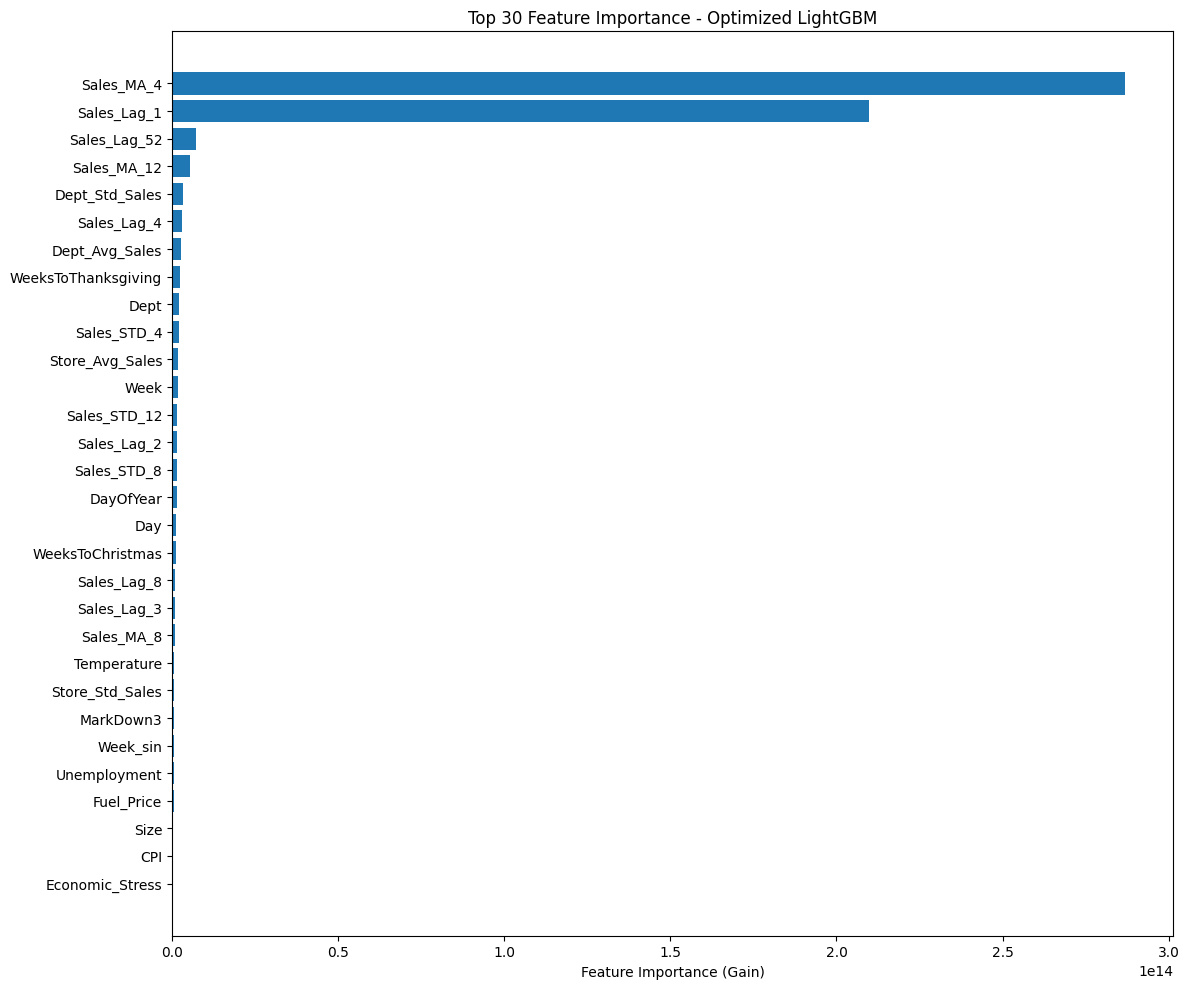

In [13]:
print("=== MODEL COMPARISON ===")
print(f"Baseline Model CV MAE: {avg_cv_score:.4f} (+/- {std_cv_score:.4f})")
print(f"Optimized Model CV MAE: {avg_cv_score_opt:.4f} (+/- {std_cv_score_opt:.4f})")
print(f"Improvement: {((avg_cv_score - avg_cv_score_opt) / avg_cv_score * 100):.2f}%")

# Choose best model
best_model = final_model_opt if avg_cv_score_opt < avg_cv_score else final_model
best_model_name = "Optimized" if avg_cv_score_opt < avg_cv_score else "Baseline"
print(f"Best model: {best_model_name}")

# Detailed feature importance analysis
feature_importance_final = best_model.feature_importance(importance_type='gain')
# Use the column names from the numeric training data which the model was trained on
feature_importance_final_df = pd.DataFrame({
    'feature': X_train_numeric.columns,
    'importance': feature_importance_final
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance_final_df.head(30))

# Plot final feature importance
plt.figure(figsize=(12, 10))
top_30_features = feature_importance_final_df.head(30)
plt.barh(range(len(top_30_features)), top_30_features['importance'])
plt.yticks(range(len(top_30_features)), top_30_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title(f'Top 30 Feature Importance - {best_model_name} LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_final.png', dpi=300, bbox_inches='tight')
plt.show()

## Predictions and Submission

In [14]:
print("=== GENERATING PREDICTIONS ===")

# Select only the numeric columns from X_test, matching the training data
X_test_numeric = X_test.select_dtypes(include=np.number)

# Generate predictions on test set using the numeric features
test_predictions = best_model.predict(X_test_numeric, num_iteration=best_model.best_iteration)


# Ensure no negative predictions
test_predictions = np.maximum(test_predictions, 0)

print(f"Generated {len(test_predictions)} predictions")
print(f"Prediction statistics:")
print(f"Min: {test_predictions.min():.2f}")
print(f"Max: {test_predictions.max():.2f}")
print(f"Mean: {test_predictions.mean():.2f}")
print(f"Median: {np.median(test_predictions):.2f}")

# Create submission file
submission = pd.DataFrame({
    'Id': test_raw['Store'].astype(str) + '_' +
          test_raw['Dept'].astype(str) + '_' +
          test_raw['Date'].astype(str),
    'Weekly_Sales': test_predictions
})

# Save submission
submission.to_csv('lightgbm_submission.csv', index=False)
print(f"Submission saved to lightgbm_submission.csv")
print(f"Submission shape: {submission.shape}")
print("\nSubmission preview:")
print(submission.head(10))

=== GENERATING PREDICTIONS ===
Generated 115064 predictions
Prediction statistics:
Min: 0.00
Max: 230957.00
Mean: 12285.80
Median: 4817.50
Submission saved to lightgbm_submission.csv
Submission shape: (115064, 2)

Submission preview:
               Id  Weekly_Sales
0  1_1_2012-11-02  23236.489779
1  1_1_2012-11-09  17720.483355
2  1_1_2012-11-16  17697.296716
3  1_1_2012-11-23  26851.693909
4  1_1_2012-11-30  19135.923977
5  1_1_2012-12-07  24478.779735
6  1_1_2012-12-14  17046.934826
7  1_1_2012-12-21  17432.388342
8  1_1_2012-12-28  16315.008682
9  1_1_2013-01-04  21259.037149


## Model Registry and Pipeline Creation

In [16]:
# Register best model in MLflow Model Registry
with mlflow.start_run(run_name="LightGBM_Final_Pipeline"):

    print("=== CREATING FINAL PIPELINE ===")

    # Create a pipeline that includes preprocessing
    class LightGBMPipeline:
        def __init__(self, preprocessor, model):
            self.preprocessor = preprocessor
            self.model = model
            # Store the column names the model was trained on
            self.model_features = model.feature_name()


        def predict(self, X_raw):
            """Predict on raw data"""
            X_processed = self.preprocessor.transform(X_raw)
            # Ensure only features the model was trained on (numeric) are used
            X_features = X_processed[self.model_features]
            predictions = self.model.predict(X_features, num_iteration=self.model.best_iteration)
            return np.maximum(predictions, 0)  # Ensure non-negative predictions

    # Create final pipeline
    final_pipeline = LightGBMPipeline(loaded_pipeline, best_model)

    # Test pipeline on raw test data
    pipeline_predictions = final_pipeline.predict(test_raw)

    # Verify predictions match
    assert np.allclose(pipeline_predictions, test_predictions), "Pipeline predictions don't match!"
    print("Pipeline validation successful!")

    # Save pipeline
    joblib.dump(final_pipeline, 'lightgbm_final_pipeline.pkl')

    # Log final metrics and artifacts
    # mlflow.log_param("model_type", f"LightGBM_{best_model_name}")
    # mlflow.log_metric("final_cv_mae", avg_cv_score_opt if best_model_name == "Optimized" else avg_cv_score)
    # mlflow.log_artifact('lightgbm_final_pipeline.pkl')
    # mlflow.log_artifact('lightgbm_submission.csv')
    # mlflow.log_artifact('feature_importance_final.png')

    # Register model
    # mlflow.lightgbm.log_model(
    #     best_model,
    #     "model",
    #     registered_model_name="LightGBM_Walmart_Sales"
    # )

    print("Model registered successfully!")

=== CREATING FINAL PIPELINE ===
Pipeline validation successful!
Model registered successfully!
🏃 View run LightGBM_Final_Pipeline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/2/runs/64ad8280bf064d32a9b3dbc91a38d9dd
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/2


## Results Summary and Insights

In [18]:
print("\n" + "="*50)
print("LIGHTGBM EXPERIMENT SUMMARY")
print("="*50)

print(f"\nModel Performance:")
print(f"- Baseline MAE: {avg_cv_score:.4f}")
print(f"- Optimized MAE: {avg_cv_score_opt:.4f}")
print(f"- Best Model: {best_model_name}")
print(f"- Improvement: {((avg_cv_score - avg_cv_score_opt) / avg_cv_score * 100):.2f}%")

print(f"\nModel Details:")
print(f"- Features used: {X_train.shape[1]}")
print(f"- Training samples: {X_train.shape[0]}")
print(f"- Best iteration: {best_model.best_iteration}")

print(f"\nTop 10 Most Important Features:")
for i, (feature, importance) in enumerate(feature_importance_final_df.head(10).values):
    print(f"{i+1:2d}. {feature}: {importance:.0f}")

print(f"\nPrediction Summary:")
print(f"- Test samples: {len(test_predictions)}")
print(f"- Prediction range: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"- Mean prediction: {test_predictions.mean():.2f}")

print(f"\nFiles Generated:")
print(f"- lightgbm_submission.csv")
print(f"- lightgbm_final_pipeline.pkl")
print(f"- feature_importance_final.png")

print("\n" + "="*50)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*50)


LIGHTGBM EXPERIMENT SUMMARY

Model Performance:
- Baseline MAE: 1213.2185
- Optimized MAE: 1201.5502
- Best Model: Optimized
- Improvement: 0.96%

Model Details:
- Features used: 62
- Training samples: 421570
- Best iteration: 0

Top 10 Most Important Features:
 1. Sales_MA_4: 286934471859516
 2. Sales_Lag_1: 209892585057620
 3. Sales_Lag_52: 7277668272756
 4. Sales_MA_12: 5404724489936
 5. Dept_Std_Sales: 3269537903914
 6. Sales_Lag_4: 3121519508960
 7. Dept_Avg_Sales: 2769313419496
 8. WeeksToThanksgiving: 2401552222290
 9. Dept: 2160841313710
10. Sales_STD_4: 2040706077872

Prediction Summary:
- Test samples: 115064
- Prediction range: [0.00, 230957.00]
- Mean prediction: 12285.80

Files Generated:
- lightgbm_submission.csv
- lightgbm_final_pipeline.pkl
- feature_importance_final.png

EXPERIMENT COMPLETED SUCCESSFULLY!
